#### Feature extraction experiment testing
* Ensamble the candidate models with the feature extraction module
* Create 2 input widgets for jupyter notebook
* Test the model with images.

Candidate models:
* vit_model_optuna run 9
* vit_model_optuna run 27

In [1]:
from drecg.models.feat_extraction import LFullModel, DiffFeatureDetectorParam
import torch
import pytorch_lightning as pl

hyperparams_run9 = {
    "num_hidden": 1,
    "hidden_units": 73,
    "features_dropout": 0.3378135977791743,
    "hidden_dropout": 0.5470664657423358,
}

hyperparams_run27 = {
    "num_hidden": 1,
    "hidden_units": 172,
    "features_dropout": 0.4518609460209016,
    "hidden_dropout": 0.6396503897330672,
}

model_run9 = DiffFeatureDetectorParam(**hyperparams_run9)
model_run27 = DiffFeatureDetectorParam(**hyperparams_run27)

model_run9.load_state_dict(torch.load(f"checkpoints/9.ckpt"))
model_run27.load_state_dict(torch.load(f"checkpoints/27.ckpt"))

<All keys matched successfully>

#### Verify and test the candidate models

In [3]:
from drecg.data.utils import FeaturesDataset
from torch.utils.data import DataLoader

test_dataset = FeaturesDataset('features_ext_vit/test_features.pt')
test_feat_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

trainer = pl.Trainer(max_epochs=1, accelerator='gpu', devices=1)
trainer.test(model=LFullModel(model_run9), dataloaders=test_feat_dataloader);
trainer.test(model=LFullModel(model_run27), dataloaders=test_feat_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      accuracy:test          0.884393036365509
        loss:test           0.3209511637687683
          step                      1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      accuracy:test         0.8872832655906677
        loss:test           0.31968048214912415
          step                      1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/daniel/mambaforge/envs/recg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:289: UserWarning: The ``compute`` method of metric _ResultMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  rank_zero_warn(


#### Create feature extraction module

In [2]:
from drecg.models.feat_extraction import VitFeatureExtractorCore
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feat_extractor = VitFeatureExtractorCore()

#### Test and verify feature extraction module

In [3]:
from drecg.data.utils import create_dataloader_train, create_dataloader_test, create_dataloader_validation, preview_image_data
dl = create_dataloader_train(transforms=feat_extractor.transforms)
x, y = next(iter(dl))
img_a, img_b = x[0].to(device), x[1].to(device)

In [ ]:
# feat_extractor.eval()
# with torch.no_grad():
#     feat_a, feat_b = feat_extractor((img_a, img_b))
# feat_a.shape, feat_b.shape

#### Create ensamble model

In [4]:
from torch import nn

class SameDogDetector(nn.Module):
    def __init__(self, feat_extractor, cls_header):
        super().__init__()
        self.feat_extractor = feat_extractor
        self.cls_header = cls_header
    
    def forward(self, x):
        features = self.feat_extractor(x)
        y = self.cls_header(features)
        return torch.sigmoid(y)

def create_same_dog_detector(cls_model):
    feat_extractor = VitFeatureExtractorCore()
    return SameDogDetector(feat_extractor, cls_model)        

In [5]:
dog_detector_r9 = create_same_dog_detector(model_run9)
dog_detector_r27 = create_same_dog_detector(model_run27)

dog_detector_r9.to(device);

In [6]:
dog_detector_r9.eval()
with torch.no_grad():
    y_pred = dog_detector_r9((img_a, img_b))
y_pred   

tensor([[2.4837e-05],
        [9.9944e-01],
        [1.5854e-04],
        [1.4597e-03],
        [9.7642e-01],
        [7.5058e-04],
        [9.8891e-01],
        [1.8794e-04],
        [9.7805e-01],
        [1.4912e-05],
        [2.0289e-01],
        [2.3110e-04],
        [5.9888e-06],
        [1.0759e-05],
        [5.3801e-04],
        [9.2999e-01],
        [3.7406e-04],
        [1.2305e-01],
        [9.7158e-01],
        [3.5921e-06],
        [9.6740e-01],
        [3.8832e-04],
        [3.2332e-03],
        [9.7155e-05],
        [9.9431e-01],
        [9.8315e-01],
        [7.6882e-02],
        [9.8583e-01],
        [9.9797e-01],
        [2.4660e-01],
        [9.1961e-01],
        [3.0047e-08]], device='cuda:0')

In [7]:
y

tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0])

In [8]:
y_pred.view_as(y).round().to(torch.int64).cpu()

tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0])

In [9]:
import PIL.Image as Image


In [19]:
import ipywidgets as widgets
from IPython.display import display

In [21]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [187]:
img_1a = Image.open('samples/13b.png')
img_1b = Image.open('samples/8b.png')

#To rgb
img_1a = img_1a.convert('RGB')
img_1b = img_1b.convert('RGB')

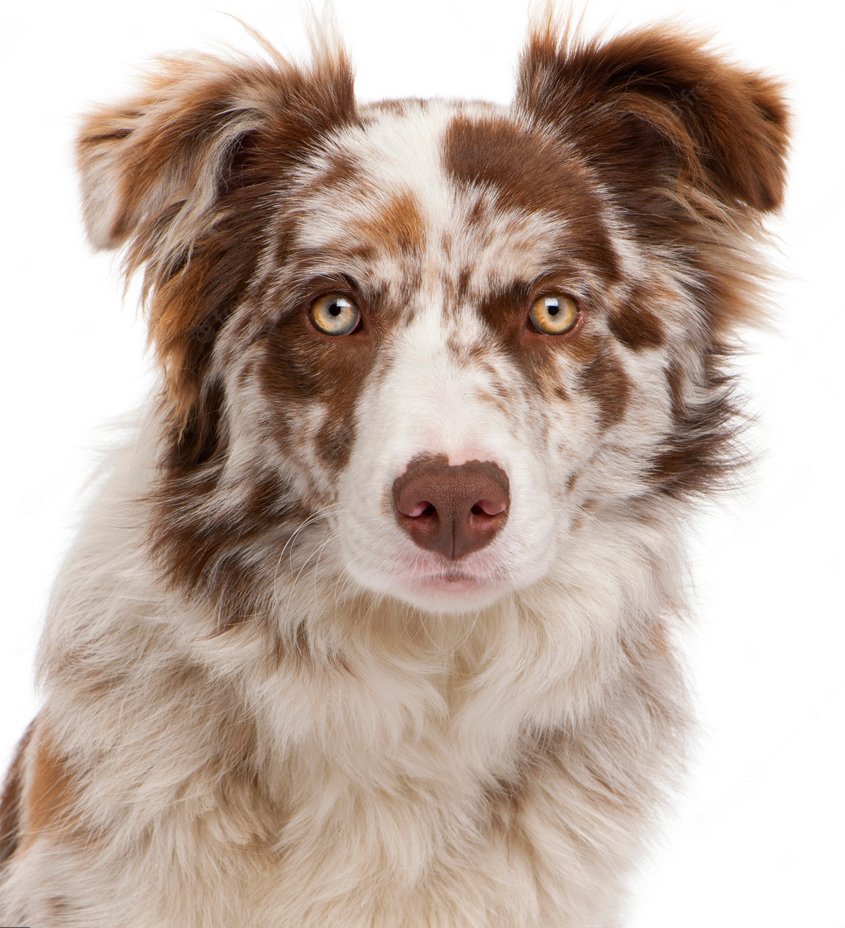

In [188]:
img_1a

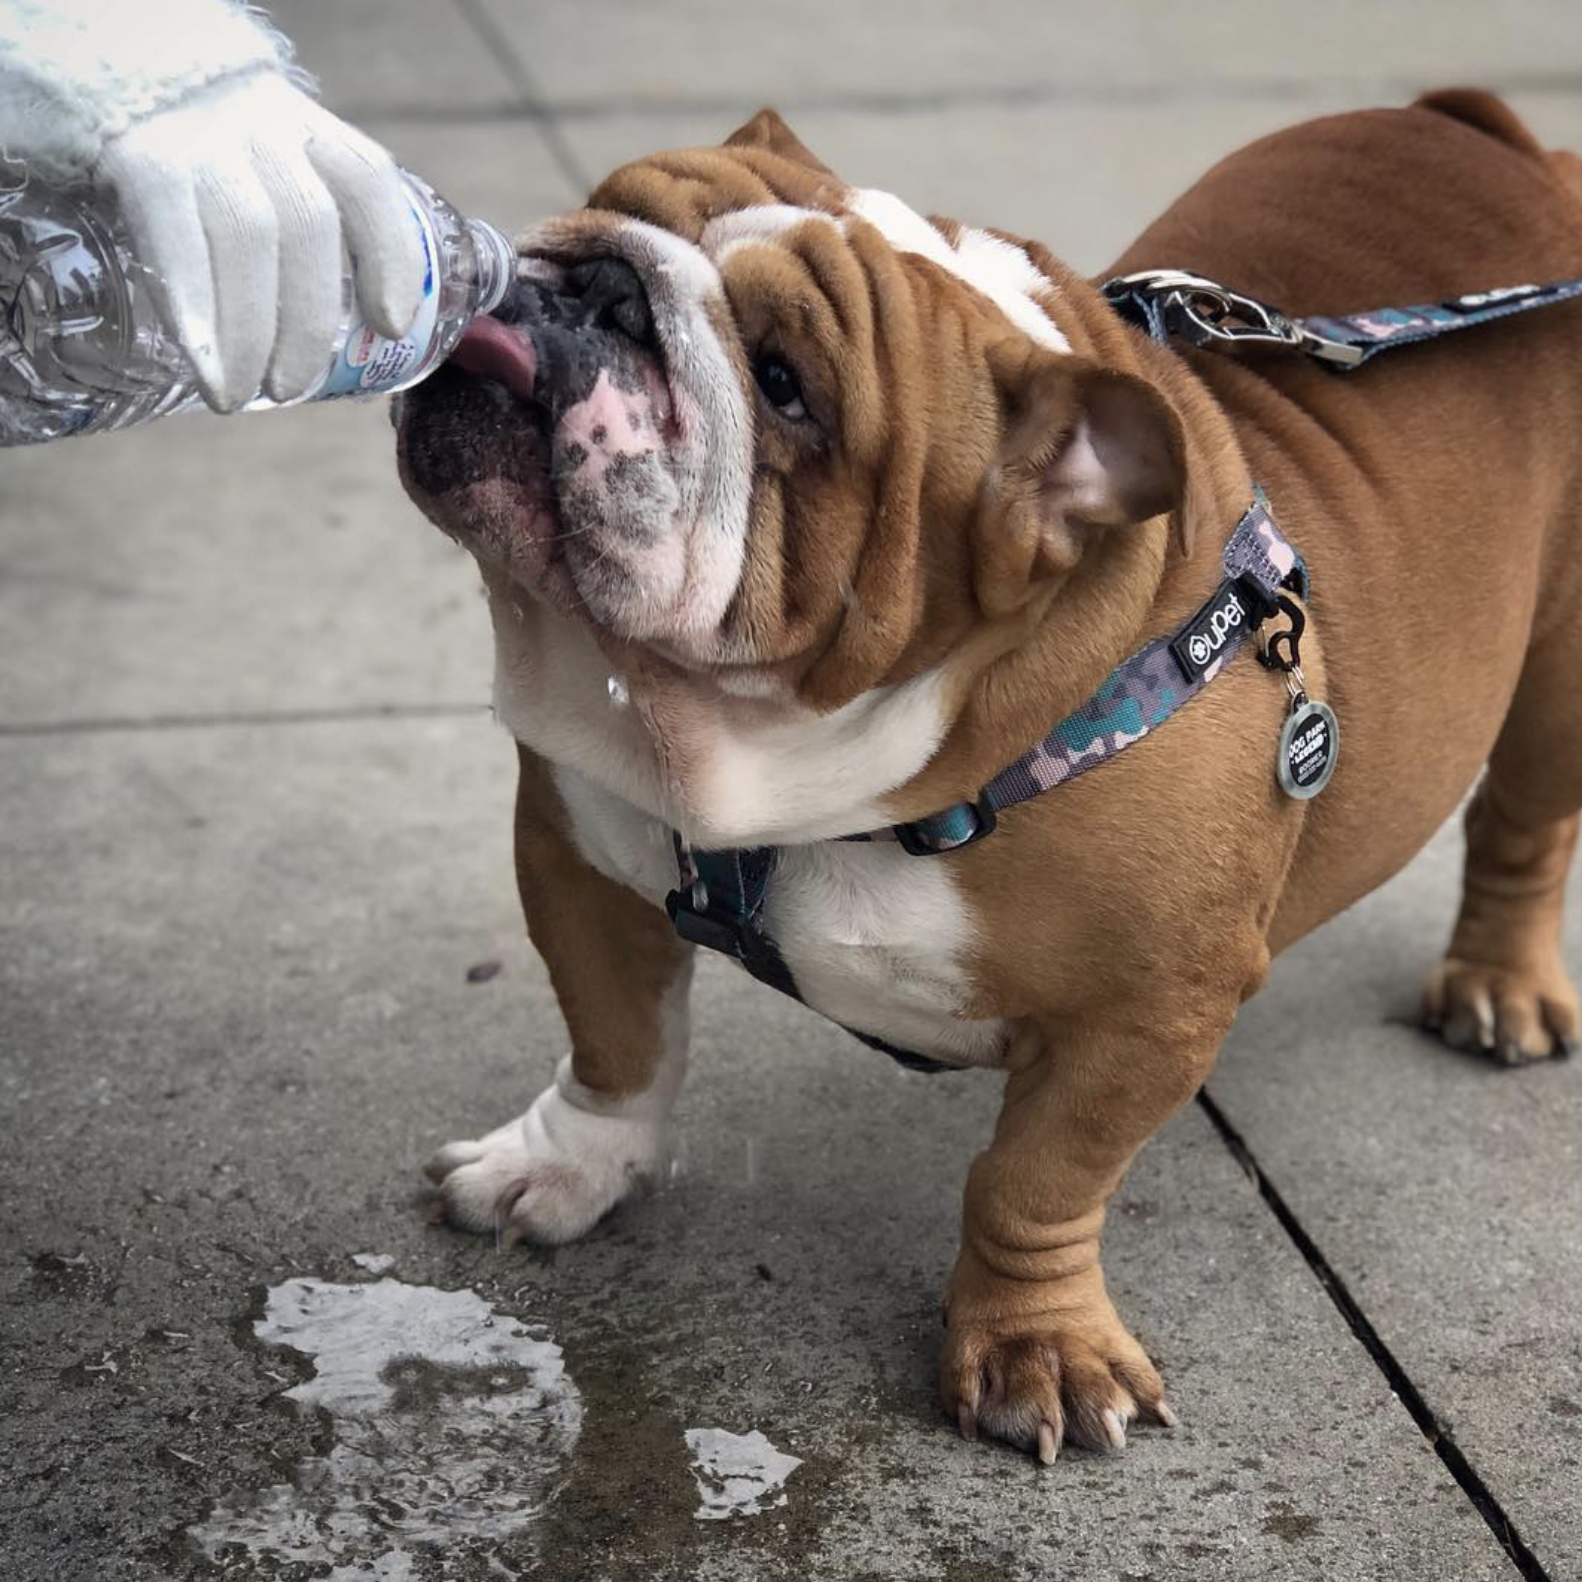

In [189]:
img_1b

In [190]:
img_1a_t = dog_detector_r9.feat_extractor.transforms(img_1a)
img_1b_t = dog_detector_r9.feat_extractor.transforms(img_1b)
img_1a_t = img_1a_t.unsqueeze(0).to(device)
img_1b_t = img_1b_t.unsqueeze(0).to(device)

dog_detector_r9.eval()
with torch.no_grad():
    y_pred = dog_detector_r9((img_1b_t, img_1a_t))

y_pred    

tensor([[0.0012]], device='cuda:0')